In [63]:
import time
import math
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn 

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from pylab import rcParams

from sklearn.neural_network import MLPClassifier

%matplotlib inline

#pip install matplotlib==3.1.0 --upgrade --force to fix confusion matrix issue

#https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75
#https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(data_copy, data_copy.target)
#tree.plot_tree(clf) 

In [64]:
data = pd.read_csv('600092_data.csv') 


# 1.0 Understanding the Data

In [65]:
data_copy = data
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
Random          1520 non-null float64
Id              1520 non-null int64
Indication      1517 non-null object
Diabetes        1518 non-null object
IHD             1520 non-null object
Hypertension    1517 non-null object
Arrhythmia      1520 non-null object
History         1518 non-null object
IPSI            1516 non-null float64
Contra          1520 non-null object
label           1517 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 83.2+ KB


In [66]:
data_copy.head()

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,0.602437,218242,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk
3,0.128157,229592,TIA,no,no,yes,no,no,90.0,85,Risk
4,0.676862,245829,CVA,no,no,no,no,no,70.0,20,NoRisk


# 2.0 Inspecting and Cleaning the Data
### 2.1 Removing Null Values

In [67]:
data_copy.isna().sum()

Random          0
Id              0
Indication      3
Diabetes        2
IHD             0
Hypertension    3
Arrhythmia      0
History         2
IPSI            4
Contra          0
label           3
dtype: int64

In [68]:
data_copy.dropna(inplace=True)

In [69]:
data_copy.isna().sum()

Random          0
Id              0
Indication      0
Diabetes        0
IHD             0
Hypertension    0
Arrhythmia      0
History         0
IPSI            0
Contra          0
label           0
dtype: int64

### 2.2 Inspecting column Random


In [71]:
data_copy['Random'].value_counts(dropna=False)

0.683506    4
0.506597    4
0.576184    4
0.899742    4
0.803415    3
           ..
0.346396    1
0.801775    1
0.972183    1
0.692722    1
0.219026    1
Name: Random, Length: 1212, dtype: int64

### 2.3 Removing column Random

In [62]:
data_copy = data_copy.drop(columns=['Random'])

### 2.4 Inspecting column Id
#### This column should contain uniques. Checking for duplicates

In [10]:
duplicateIdDF = data_copy[data_copy.duplicated(['Id'])]

if duplicateIdDF.empty :
    print ("No Duplicates")
else:
    print (duplicateIdDF)


No Duplicates


#### Removing column Id
No duplicates are present. Therefore it is assumed all data is unique. No further use for ID column and therefore dropping.

In [11]:
data_copy = data_copy.drop(columns=['Id'])

### 2.5 Inspecting column Indication

In [12]:
data_copy['Indication'].value_counts(dropna=False)

A-F    489
CVA    408
TIA    388
ASx    186
Asx     32
Name: Indication, dtype: int64

#### Setting all values to upper case
As seen above, we are reading 5 different values for Indication when there should only be 4.  
This is due to two values being the same but having different capitialisation.  
Setting all values in our data to uppercase to solve this and avoid any further errors.

In [13]:
# Change all my string data to Uppercase to avoid any
data_copy['Indication'] = data_copy['Indication'].str.upper()
data_copy['Diabetes'] = data_copy['Diabetes'].str.upper() 
data_copy['IHD'] = data_copy['IHD'].str.upper() 
data_copy['Hypertension'] = data_copy['Hypertension'].str.upper() 
data_copy['Arrhythmia'] = data_copy['Arrhythmia'].str.upper() 
data_copy['History'] = data_copy['History'].str.upper() 
data_copy['label'] = data_copy['label'].str.upper() 

data_copy['Indication'].value_counts(dropna=False)

A-F    489
CVA    408
TIA    388
ASX    218
Name: Indication, dtype: int64

In [14]:
# Displays count Indication graph

#sb.countplot(data = data_copy, x= "Indication")
#y = plt.ylabel("Amount of People")
#sb.catplot('label', col="Indication", data = data_copy,kind='count' , height = 2.5)

#### One Hot Encoding - Indication
Using One Hot Encoding to split Indication into 4 boolean columns to prevent the data being misinterpreted later on in other algorithms.
https://pbpython.com/categorical-encoding.html

In [15]:
data_copy = pd.get_dummies(data_copy, columns=["Indication"])
data_copy.head()

,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA
0,NO,NO,YES,NO,NO,78.0,20,NORISK,1,0,0,0
1,NO,NO,NO,NO,NO,70.0,60,NORISK,0,0,0,1
2,NO,YES,YES,NO,NO,95.0,40,RISK,1,0,0,0
3,NO,NO,YES,NO,NO,90.0,85,RISK,0,0,0,1
4,NO,NO,NO,NO,NO,70.0,20,NORISK,0,0,1,0


### 2.6 Inspecting each binary column. 

In [16]:
data_copy['Diabetes'].value_counts(dropna=False)

NO     1428
YES      75
Name: Diabetes, dtype: int64

In [17]:
data_copy['IHD'].value_counts(dropna=False)

NO     791
YES    712
Name: IHD, dtype: int64

In [18]:
data_copy['Hypertension'].value_counts(dropna=False)

NO     777
YES    726
Name: Hypertension, dtype: int64

In [19]:
data_copy['Arrhythmia'].value_counts(dropna=False)

NO     1179
YES     324
Name: Arrhythmia, dtype: int64

In [20]:
data_copy['History'].value_counts(dropna=False)

NO     1481
YES      22
Name: History, dtype: int64

#### Changing each binary column to display True for YES and False for NO.
Setting these values to true and false will make them readable to algorithms and models later on

In [21]:
# Creating a map to change YES and NO to True and False respectively
yesToTrue = {'YES': True,'NO': False}

# Creating new columns in our data, Displaying True or False instead
data_copy = data_copy.assign(Diabetes_bool = data_copy['Diabetes'].map(yesToTrue),
                      IHD_bool = data_copy['IHD'].map(yesToTrue),
                      Hypertension_bool = data_copy['Hypertension'].map(yesToTrue),
                      Arrhythmia_bool = data_copy['Arrhythmia'].map(yesToTrue),
                      History_bool = data_copy['History'].map(yesToTrue))

# Now dropping the old columns which displayed YES or NO
data_copy = data_copy.drop(columns=['Diabetes','IHD','Hypertension','Arrhythmia','History'])

data_copy.head()


,IPSI,Contra,label,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA,Diabetes_bool,IHD_bool,Hypertension_bool,Arrhythmia_bool,History_bool
0,78.0,20,NORISK,1,0,0,0,False,False,True,False,False
1,70.0,60,NORISK,0,0,0,1,False,False,False,False,False
2,95.0,40,RISK,1,0,0,0,False,True,True,False,False
3,90.0,85,RISK,0,0,0,1,False,False,True,False,False
4,70.0,20,NORISK,0,0,1,0,False,False,False,False,False


### 2.7 Inspecting column Contra

In [22]:
data_copy['Contra'].value_counts(dropna=False)

100     238
20      191
30      150
50      131
40      101
60       93
50       51
10       49
100      39
70       34
90       34
95       32
75       31
25       30
75       29
80       29
80       24
85       24
35       22
70       18
15       18
55       14
65       13
30       12
51       11
85       11
90       10
53        9
55        9
73        7
40        7
60        6
45        6
35        5
65        4
16        4
62        3
79        2
          1
10        1
Name: Contra, dtype: int64

#### Compare column Contra to IPSI
An empty value is present in Contra.  
Will compare to IPSI to see if any coorelation is present.

Text(0.5, 0, 'Contra')

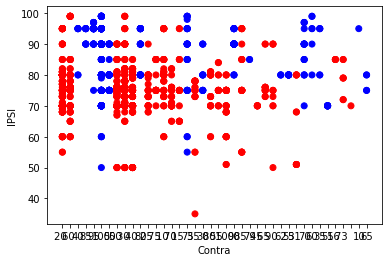

In [23]:
colour = data_copy.label.map({'RISK':'b','NORISK':'r', 'UNKNOWN':'g', 'NAN':'y' })
ax1 = plt.scatter(data_copy['Contra'], data_copy['IPSI'],c= colour)
ax1.axes.set_ylabel('IPSI')
ax1.axes.set_xlabel('Contra')

#### Turning empty value in Contra to NaN
No correlation was found between Contra and IPSI alone. Therefore changing the value to NaN and will drop later.

In [24]:
data_copy=data_copy.replace(r'^\s*$', np.nan, regex=True)#
#data_copy.dropna(inplace=True)
#data_copy['Contra'].value_counts(dropna=False)

### 2.8 Inspect column label


In [25]:
data_copy['label'].value_counts(dropna=False)

NORISK     1001
RISK        500
UNKNOWN       2
Name: label, dtype: int64

#### Removing records contain UNKNOWN
Column lable contains two UNKNOWN values.   
Changing these to NaN and dropping

In [26]:
data_copy['label'] = data_copy['label'].replace("UNKNOWN", np.nan)
data_copy.dropna(inplace=True)

In [27]:
# Creating a map to change YES and NO to True and False respectively
riskToTrue = {'RISK': 1,'NORISK': 0}

data_copy = data_copy.assign(label_bool = data_copy['label'].map(riskToTrue))
data_copy = data_copy.drop(columns=['label'])
data_copy.head()

,IPSI,Contra,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA,Diabetes_bool,IHD_bool,Hypertension_bool,Arrhythmia_bool,History_bool,label_bool
0,78.0,20,1,0,0,0,False,False,True,False,False,0
1,70.0,60,0,0,0,1,False,False,False,False,False,0
2,95.0,40,1,0,0,0,False,True,True,False,False,1
3,90.0,85,0,0,0,1,False,False,True,False,False,1
4,70.0,20,0,0,1,0,False,False,False,False,False,0


# 3.0 Data Models
Will be creating multiple models to analyse the data.  
These models will be using a 70%-30% split of training and test data respectively.

## 3.1 Defining Test and Training Data
### Define X & Y.  
X being our cleaned and filtered data without the label column.  
Y being our label values.

In [28]:
# Define our x and y values for our training model
# X contains all columns except label
X = data_copy.drop(columns=['label_bool'])

# Y contains label values.
Y = data_copy['label_bool'].values

### Create train test split
Once we have our X and Y, we can split our data into 30% test data and 70% training data

In [29]:
xTrain, xTest, yTrain, yTest = train_test_split(X,Y,test_size=0.3, shuffle=True)

## 3.2 Nearest Neighbour Model (KNN)
https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a  
https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75   
https://www.quora.com/How-can-I-choose-the-best-K-in-KNN-K-nearest-neighbour-classification  
KNN model requires a value K. K determines how many neighbours are used to decide a given value.

To find the best value for K, we will create multiple KNN models with different K values and inspect each of their accuracies.

### 3.2.1 Finding a value for K - Using Predictor

In [30]:
k_range = range(1,50)
knn_scores = {}
knn_scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric ='euclidean')
    knn.fit(xTrain,yTrain)
    yPred = knn.predict(xTest)
    knn_scores[k] = metrics.accuracy_score(yTest,yPred)
    knn_scores_list.append(metrics.accuracy_score(yTest,yPred))

[0.98, 0.9688888888888889, 0.96, 0.9577777777777777, 0.9488888888888889, 0.9377777777777778, 0.9333333333333333, 0.9222222222222223, 0.9266666666666666, 0.9177777777777778, 0.92, 0.9177777777777778, 0.92, 0.92, 0.9222222222222223, 0.92, 0.9133333333333333, 0.9111111111111111, 0.9155555555555556, 0.9111111111111111, 0.8977777777777778, 0.9, 0.8977777777777778, 0.8955555555555555, 0.8955555555555555, 0.8911111111111111, 0.8911111111111111, 0.8866666666666667, 0.8777777777777778, 0.88, 0.8733333333333333, 0.8777777777777778, 0.8777777777777778, 0.8777777777777778, 0.88, 0.8888888888888888, 0.8822222222222222, 0.8844444444444445, 0.8888888888888888, 0.8933333333333333, 0.8822222222222222, 0.8911111111111111, 0.8822222222222222, 0.8644444444444445, 0.8577777777777778, 0.8622222222222222, 0.86, 0.8622222222222222, 0.8622222222222222]


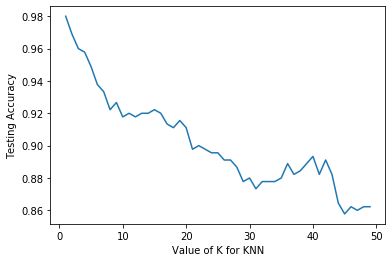

In [31]:
plt.plot(k_range,knn_scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print(knn_scores_list)
## 0.98, 0.9822, 0.991, 0.984

### 3.2.2 Finding a value for K - Using K-Fold Cross Validation

[0.9853333333333334, 0.9773333333333335, 0.9673333333333334, 0.9566666666666667, 0.9493333333333333, 0.9433333333333334, 0.938, 0.9346666666666665, 0.9306666666666666, 0.9213333333333334, 0.9173333333333333, 0.916, 0.914, 0.9093333333333333, 0.9113333333333333, 0.9120000000000001, 0.9120000000000001, 0.9113333333333336, 0.9066666666666666, 0.9073333333333332, 0.9046666666666667, 0.9026666666666665, 0.9013333333333333, 0.8986666666666668, 0.8986666666666666, 0.8960000000000001, 0.8966666666666667, 0.8959999999999999, 0.8979999999999999, 0.89, 0.8826666666666668, 0.8806666666666668, 0.8753333333333334, 0.876, 0.8753333333333332, 0.876, 0.8753333333333334, 0.8753333333333334, 0.876, 0.8746666666666666, 0.8766666666666667, 0.8753333333333334, 0.8766666666666667, 0.8766666666666667, 0.876, 0.8773333333333333, 0.8766666666666667, 0.8766666666666666, 0.8766666666666666]


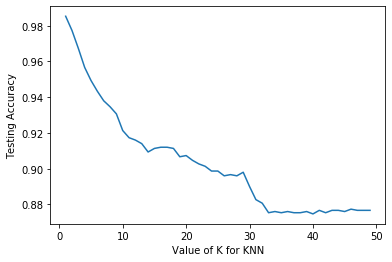

In [32]:
cv_scores = {}
cv_scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric ='euclidean')
    cv_scores[k] = np.mean(cross_val_score(knn, X, Y, cv=10))
    cv_scores_list.append(cv_scores[k])
    
plt.plot(k_range,cv_scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print(cv_scores_list)

### 3.2.3 Finding a value for K - Square root n  
n being the number of data points

In [33]:
print (math.sqrt(len(yTrain)))

32.4037034920393


### 3.2.4 Implementing K into KNN model
Setting k to 31.

In [34]:
# Create our KNN classifier. Setting K to 31
knn = KNeighborsClassifier(n_neighbors = 31)
 
# Fit our trained data in the classifer
knn.fit (xTrain, yTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

### 3.2.5 Accuracy of KNN Model

In [35]:
# Check accuracy of our model
knn.score(xTest, yTest)

0.8733333333333333

In [36]:
print(metrics.classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       296
           1       0.82      0.77      0.79       154

    accuracy                           0.86       450
   macro avg       0.85      0.84      0.84       450
weighted avg       0.86      0.86      0.86       450



## 3.3 Decision Tree Model
https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d

### 3.3.1 Implementing Decision Tree Model

[Text(736.046052631579, 1019.25, 'X[9] <= 0.5\ngini = 0.442\nsamples = 1050\nvalue = [704, 346]'),
 Text(473.5657894736842, 883.35, 'X[1] <= 61.0\ngini = 0.258\nsamples = 821\nvalue = [696, 125]'),
 Text(301.0263157894737, 747.45, 'X[0] <= 87.5\ngini = 0.066\nsamples = 589\nvalue = [569, 20]'),
 Text(190.89473684210526, 611.55, 'X[6] <= 0.5\ngini = 0.033\nsamples = 534\nvalue = [525, 9]'),
 Text(117.47368421052632, 475.65, 'X[2] <= 0.5\ngini = 0.026\nsamples = 529\nvalue = [522, 7]'),
 Text(58.73684210526316, 339.75, 'X[3] <= 0.5\ngini = 0.005\nsamples = 368\nvalue = [367, 1]'),
 Text(29.36842105263158, 203.85000000000002, 'gini = 0.0\nsamples = 309\nvalue = [309, 0]'),
 Text(88.10526315789474, 203.85000000000002, 'X[1] <= 42.5\ngini = 0.033\nsamples = 59\nvalue = [58, 1]'),
 Text(58.73684210526316, 67.95000000000005, 'gini = 0.0\nsamples = 48\nvalue = [48, 0]'),
 Text(117.47368421052632, 67.95000000000005, 'gini = 0.165\nsamples = 11\nvalue = [10, 1]'),
 Text(176.21052631578948, 339.7

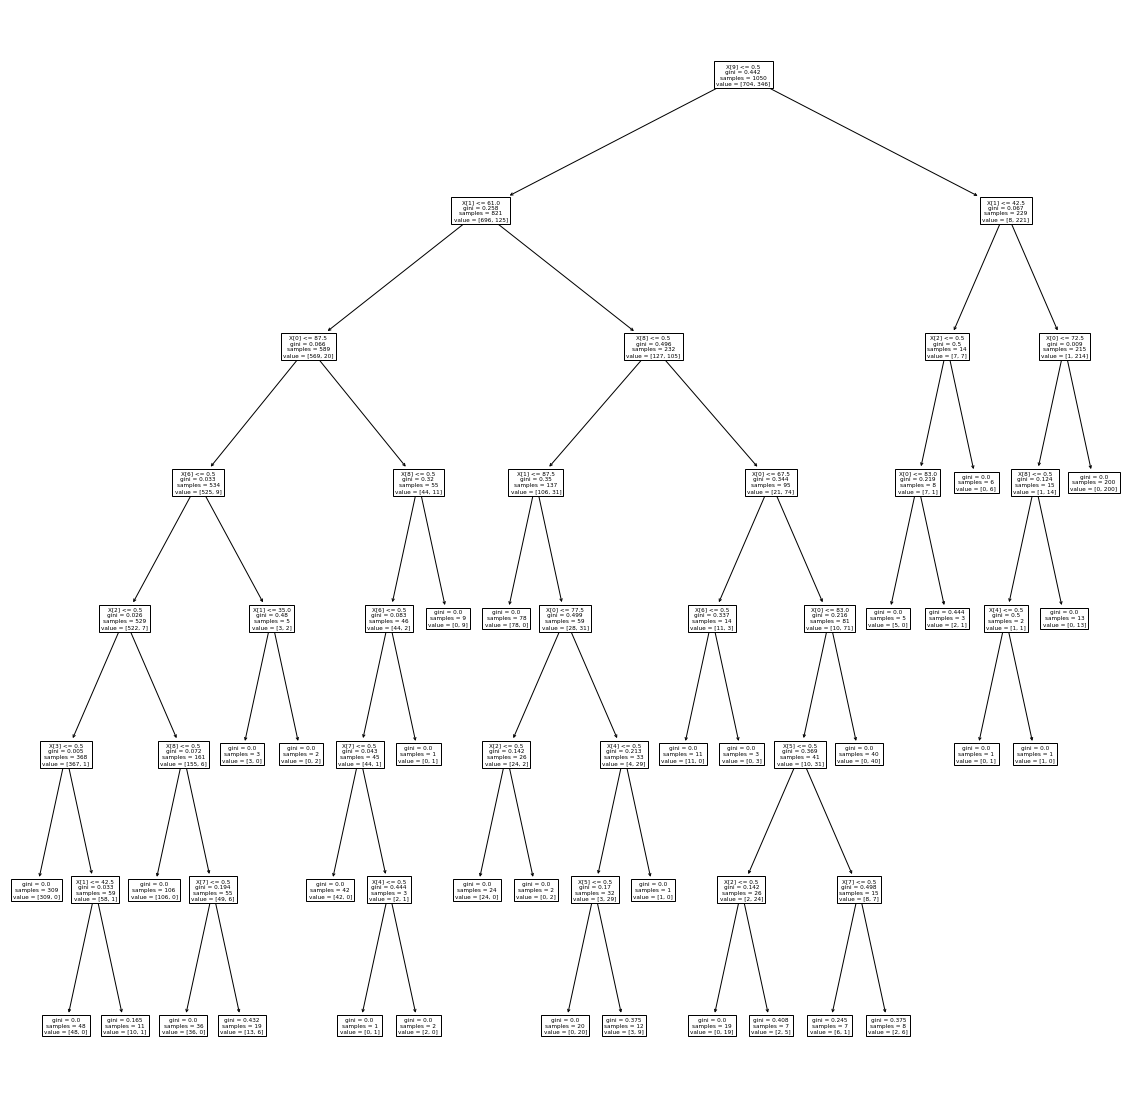

In [37]:
clf = tree.DecisionTreeClassifier(max_depth = 7)
clf = clf.fit(xTrain, yTrain)
plt.rcParams["figure.figsize"] = (20,20)
tree.plot_tree(clf) 


### 3.3.2 Accuracy of Decision Tree Model

In [38]:
yPred = clf.predict(xTest)
print("Accuracy:",metrics.accuracy_score(yTest, yPred))
print("Mean Absolute Error:", metrics.mean_absolute_error(yTest, yPred))
print("Mean Squared Error:", metrics.mean_squared_error(yTest,yPred))

Accuracy: 0.9755555555555555
Mean Absolute Error: 0.024444444444444446
Mean Squared Error: 0.024444444444444446


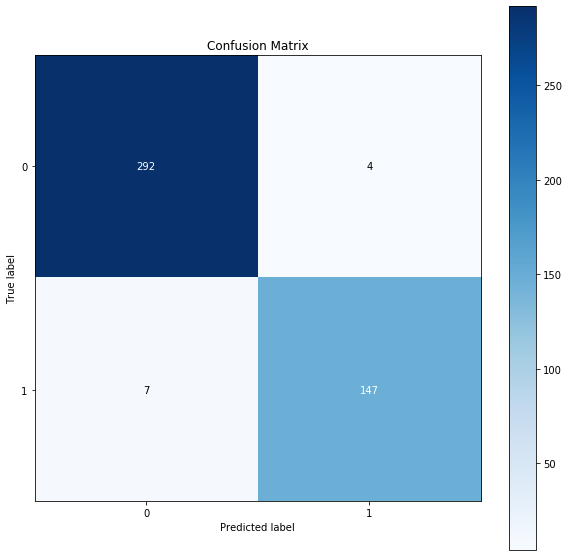

In [39]:
plt.rcParams["figure.figsize"] = (10,10)
skplt.metrics.plot_confusion_matrix(y_true= yTest, y_pred = yPred)

## 3.4 Multi-Layer Perceptron

### 3.4.1 Implementing Multi-Layer Perceptron

In [40]:
model = MLPClassifier(solver='sgd',activation='logistic',max_iter=5000000, hidden_layer_sizes=(400))
trained_model = model.fit(xTrain,yTrain)
model_prediction = trained_model.predict(xTest)

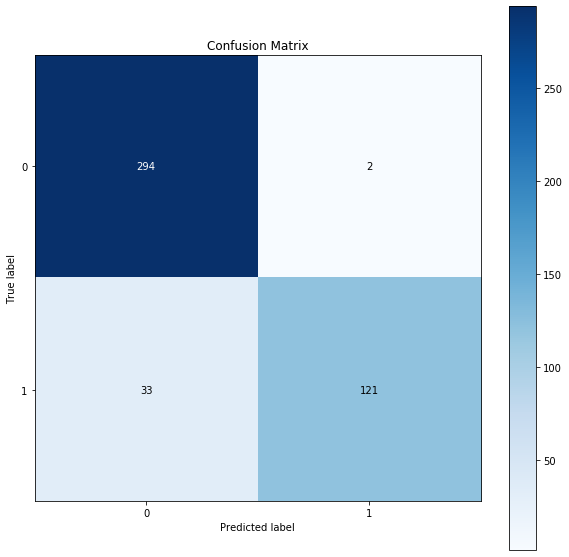

In [41]:
skplt.metrics.plot_confusion_matrix(y_true = yTest, y_pred = model_prediction)

### 3.4.2 Accuracy of Multi-Layer Perceptron

In [42]:
metrics.accuracy_score(yTest,model_prediction)

0.9222222222222223

# 4.0 Reinspection of data

### 4.1 Heatmap of our variables

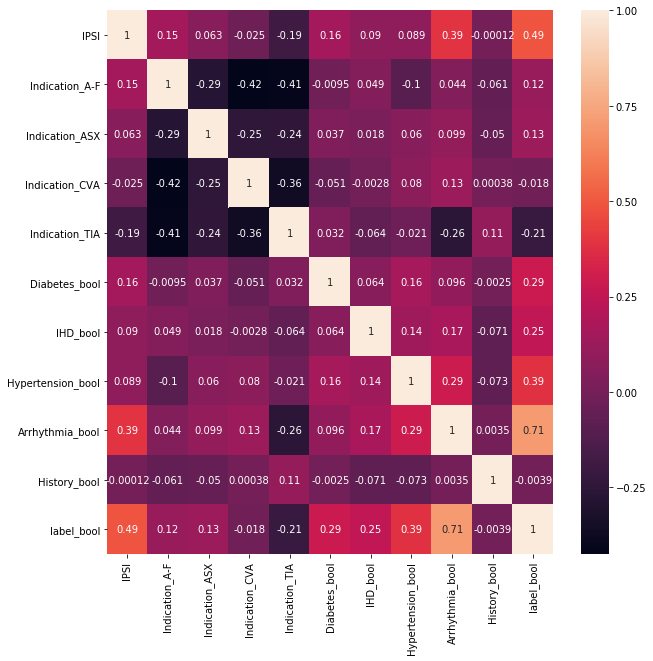

In [43]:
sb.heatmap(data_copy.corr(),annot=True,fmt = '.2g')

The heatmap above suggests that compared to 'label_bool', the Indication values and History have little to no coorelation.

In [44]:
data_copy=data_copy.drop(columns=['History_bool','Indication_A-F','Indication_ASX','Indication_CVA','Indication_TIA'])
data_copy.head()

,IPSI,Contra,Diabetes_bool,IHD_bool,Hypertension_bool,Arrhythmia_bool,label_bool
0,78.0,20,False,False,True,False,0
1,70.0,60,False,False,False,False,0
2,95.0,40,False,True,True,False,1
3,90.0,85,False,False,True,False,1
4,70.0,20,False,False,False,False,0


# 5.0 Re-Run Models with new Data

### Defining X & Y

In [45]:
# X contains all columns except label
X = data_copy.drop(columns=['label_bool'])

# Y contains label values.
Y = data_copy['label_bool'].values

### Create train test split

In [46]:
xTrain, xTest, yTrain, yTest = train_test_split(X,Y,test_size=0.3, shuffle=True)

## KNN Model

In [47]:
# Create our KNN classifier. Setting K to 31
knn = KNeighborsClassifier(n_neighbors = 31)
 
# Fit our trained data in the classifer
knn.fit (xTrain, yTrain)

# Check accuracy of our model 
knn.score(xTest, yTest)

0.8866666666666667

In [48]:
print(metrics.classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       305
           1       0.30      0.31      0.30       145

    accuracy                           0.54       450
   macro avg       0.48      0.48      0.48       450
weighted avg       0.55      0.54      0.54       450



## Decision Tree Model

[Text(685.875, 1045.3846153846155, 'X[5] <= 0.5\ngini = 0.448\nsamples = 1050\nvalue = [695, 355]'),
 Text(415.1785714285714, 961.7538461538462, 'X[1] <= 61.0\ngini = 0.266\nsamples = 815\nvalue = [686, 129]'),
 Text(240.47142857142856, 878.123076923077, 'X[2] <= 0.5\ngini = 0.07\nsamples = 579\nvalue = [558, 21]'),
 Text(172.7142857142857, 794.4923076923078, 'X[0] <= 87.5\ngini = 0.058\nsamples = 569\nvalue = [552, 17]'),
 Text(100.97142857142856, 710.8615384615384, 'X[3] <= 0.5\ngini = 0.034\nsamples = 515\nvalue = [506, 9]'),
 Text(79.71428571428571, 627.2307692307693, 'gini = 0.0\nsamples = 296\nvalue = [296, 0]'),
 Text(122.22857142857143, 627.2307692307693, 'X[4] <= 0.5\ngini = 0.079\nsamples = 219\nvalue = [210, 9]'),
 Text(42.51428571428571, 543.6, 'X[0] <= 79.5\ngini = 0.014\nsamples = 139\nvalue = [138, 1]'),
 Text(21.257142857142856, 459.96923076923076, 'gini = 0.0\nsamples = 106\nvalue = [106, 0]'),
 Text(63.77142857142857, 459.96923076923076, 'X[1] <= 45.0\ngini = 0.059\ns

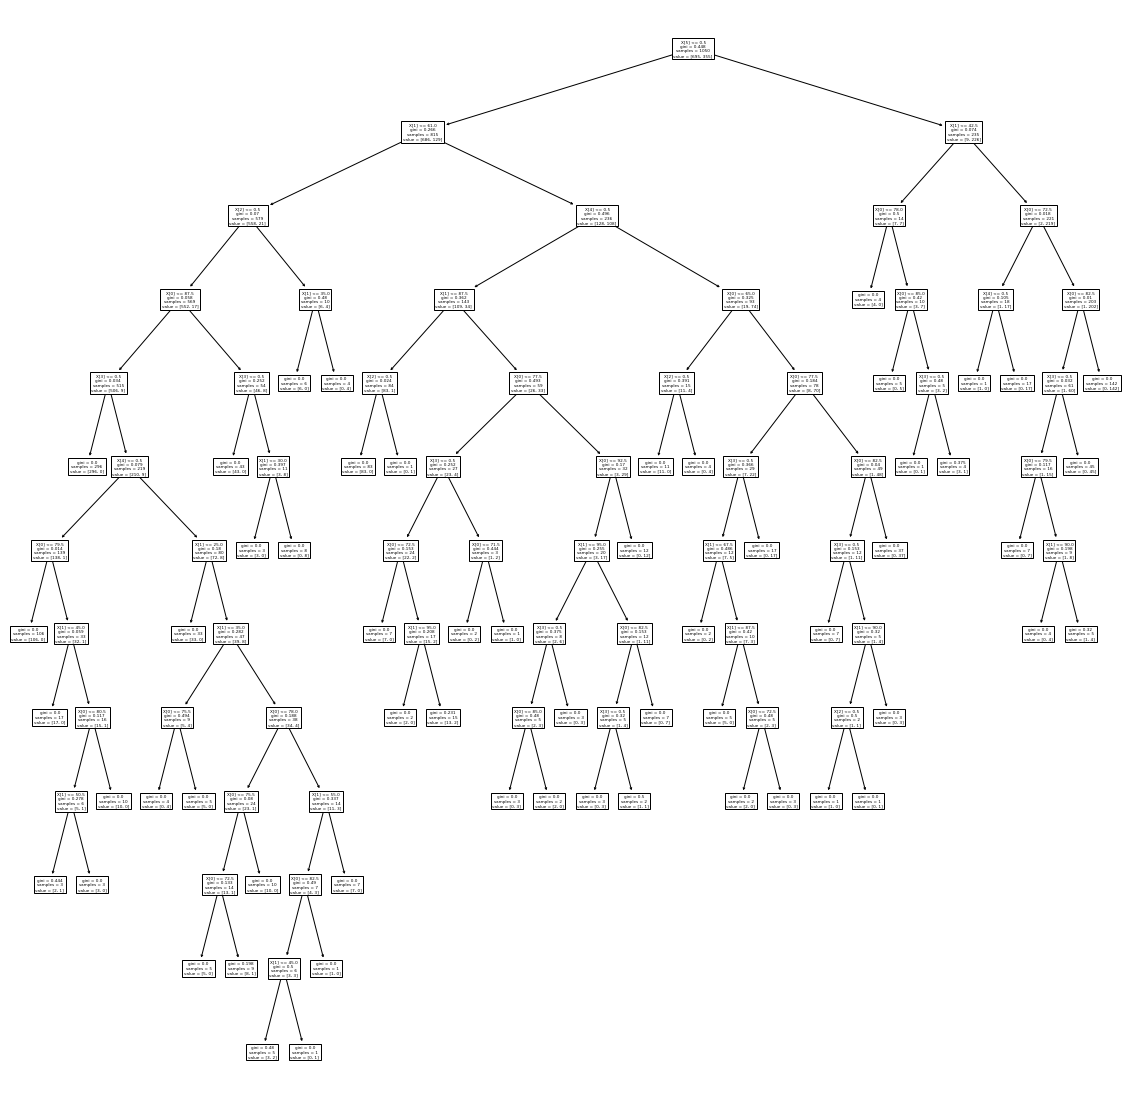

In [49]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xTrain, yTrain)
plt.rcParams["figure.figsize"] = (20,20)
tree.plot_tree(clf) 

In [50]:
yPred = clf.predict(xTest)
print("Accuracy:",metrics.accuracy_score(yTest, yPred))
print("Mean Absolute Error:", metrics.mean_absolute_error(yTest, yPred))
print("Mean Squared Error:", metrics.mean_squared_error(yTest,yPred))

Accuracy: 0.9866666666666667
Mean Absolute Error: 0.013333333333333334
Mean Squared Error: 0.013333333333333334


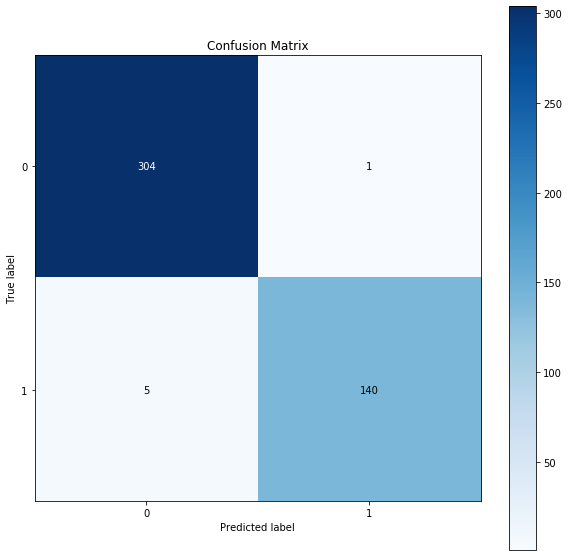

In [51]:
plt.rcParams["figure.figsize"] = (10,10)
skplt.metrics.plot_confusion_matrix(y_true= yTest, y_pred = yPred)

## Multi-Layer Perceptron

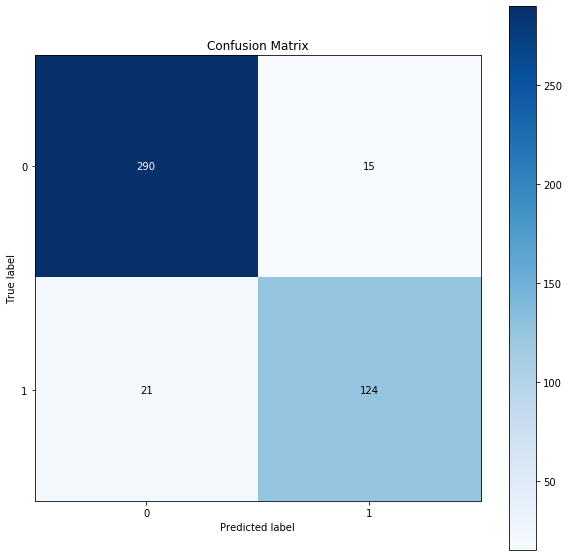

In [52]:
model = MLPClassifier(solver='sgd',activation='logistic',max_iter=5000000, hidden_layer_sizes=(400))
trained_model = model.fit(xTrain,yTrain)
model_prediction = trained_model.predict(xTest)

skplt.metrics.plot_confusion_matrix(y_true = yTest, y_pred = model_prediction)

In [53]:
metrics.accuracy_score(yTest,model_prediction)

0.92